## Initial Try for DenseNet and ConvNext

>**Initial Import**

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.applications import MobileNetV2, InceptionResNetV2, DenseNet121, ResNet50, InceptionV3
from keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Sequential
import numpy as np
import os
import torch
import keras
import pycocotools
import torch.utils.data
from PIL import Image
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from  PIL import ImageDraw
import os.path as path
import re
from sklearn.model_selection import train_test_split
from torchvision import models, transforms


>**Directory Structure and Data Fetching**

In [5]:
import os


dataset_dir = "./dataset/realwaste-main/RealWaste"


def print_directory_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for file in files:

            if not file.endswith('.jpg') and not file.endswith('.png'):
                print(f"{sub_indent}{file}")


print_directory_structure(dataset_dir)


RealWaste/
    Cardboard/
    Food Organics/
    Glass/
    Metal/
    Miscellaneous Trash/
    Paper/
    Plastic/
    Textile Trash/
    Vegetation/


In [19]:
import os
import shutil
import random
dataset_dir = "./dataset/realwaste-main/RealWaste"
train_dir = "./dataset/realwaste-main/train"
test_dir = "./dataset/realwaste-main/test"


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


train_split = 0.8


def split_data(source, train_dest, test_dest, split_ratio):
    files = os.listdir(source)
    num_files = len(files)
    num_train = int(num_files * split_ratio)
    random.shuffle(files)
    train_files = files[:num_train]
    test_files = files[num_train:]

    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(train_dest, file))
    for file in test_files:
        shutil.copy(os.path.join(source, file), os.path.join(test_dest, file))


for category in os.listdir(dataset_dir):
    category_source = os.path.join(dataset_dir, category)
    category_train_dest = os.path.join(train_dir, category)
    category_test_dest = os.path.join(test_dir, category)
    os.makedirs(category_train_dest, exist_ok=True)
    os.makedirs(category_test_dest, exist_ok=True)
    split_data(category_source, category_train_dest, category_test_dest, train_split)


In [21]:
import os


dataset_dir = "./dataset/realwaste-main"


def print_directory_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for file in files:

            if not file.endswith('.jpg') and not file.endswith('.png'):
                print(f"{sub_indent}{file}")


print_directory_structure(dataset_dir)


realwaste-main/
    README.md
    RealWaste/
        Cardboard/
        Food Organics/
        Glass/
        Metal/
        Miscellaneous Trash/
        Paper/
        Plastic/
        Textile Trash/
        Vegetation/
    test/
        Cardboard/
        Food Organics/
        Glass/
        Metal/
        Miscellaneous Trash/
        Paper/
        Plastic/
        Textile Trash/
        Vegetation/
    train/
        Cardboard/
        Food Organics/
        Glass/
        Metal/
        Miscellaneous Trash/
        Paper/
        Plastic/
        Textile Trash/
        Vegetation/


>**Data splitting with Data Augmentation Implementation**

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = "./dataset/realwaste-main/train"
test_dir = "./dataset/realwaste-main/test"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 3798 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = "./dataset/realwaste-main/train"
test_dir = "./dataset/realwaste-main/test"


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 32


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),  # adjust as needed
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # adjust as needed
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3798 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


In [3]:
image_shape_train = train_generator.image_shape
image_shape_test = test_generator.image_shape

print("Image shape for training set:", image_shape_train)
print("Image shape for test set:", image_shape_test)


Image shape for training set: (256, 256, 3)
Image shape for test set: (256, 256, 3)


>****

In [7]:
import tensorflow as tf

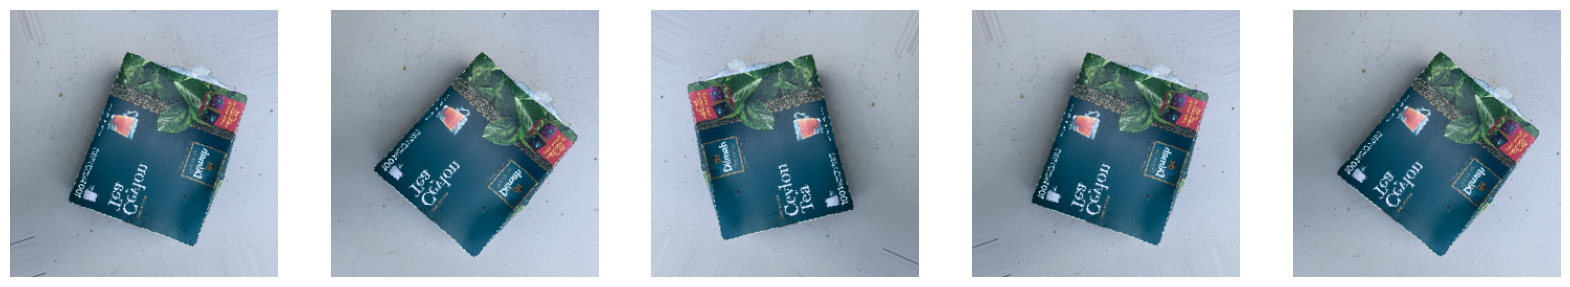

In [5]:
import matplotlib.pyplot as plt


augmented_images = [train_generator[0][0][0] for _ in range(5)]  # adjust the number of images to visualize


fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, image in enumerate(augmented_images):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()


In [8]:
densenet_base_model = tf.keras.applications.DenseNet121(input_shape=(150,150,3),include_top=False,weights='imagenet',pooling='avg')
densenet_base_model.trainable = False

In [54]:
from tensorflow.keras.layers import BatchNormalization
x = densenet_base_model.output
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)
densenet_model = Model(inputs=densenet_base_model.input, outputs=predictions)

In [47]:
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = densenet_model.fit(train_generator, validation_data=test_generator, epochs=10)


Epoch 1/10
119/119 [==============================] - 2372s 20s/step - loss: 1.5289 - accuracy: 0.4452 - val_loss: 1.0864 - val_accuracy: 0.6038
Epoch 2/10
119/119 [==============================] - 177s 1s/step - loss: 1.2128 - accuracy: 0.5629 - val_loss: 0.8878 - val_accuracy: 0.6688
Epoch 3/10
119/119 [==============================] - 175s 1s/step - loss: 1.1423 - accuracy: 0.5845 - val_loss: 0.9069 - val_accuracy: 0.6572
Epoch 4/10
119/119 [==============================] - 173s 1s/step - loss: 1.1010 - accuracy: 0.5953 - val_loss: 0.8563 - val_accuracy: 0.6803
Epoch 5/10
119/119 [==============================] - 180s 2s/step - loss: 1.0744 - accuracy: 0.6156 - val_loss: 0.8789 - val_accuracy: 0.6960
Epoch 6/10
119/119 [==============================] - 179s 2s/step - loss: 0.9761 - accuracy: 0.6430 - val_loss: 0.7833 - val_accuracy: 0.7180
Epoch 7/10
119/119 [==============================] - 180s 2s/step - loss: 1.0015 - accuracy: 0.6395 - val_loss: 0.8106 - val_accuracy: 0.70

In [ ]:
#densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#history = densenet_model.fit(train_generator, validation_data=test_generator, epochs=20)

In [49]:
#densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = densenet_model.fit(train_generator, validation_data=test_generator, epochs=30)


Epoch 1/30
119/119 [==============================] - 189s 2s/step - loss: 0.7561 - accuracy: 0.7259 - val_loss: 0.6621 - val_accuracy: 0.7736
Epoch 2/30
119/119 [==============================] - 178s 1s/step - loss: 0.7141 - accuracy: 0.7372 - val_loss: 0.6359 - val_accuracy: 0.7715
Epoch 3/30
119/119 [==============================] - 182s 2s/step - loss: 0.7150 - accuracy: 0.7333 - val_loss: 0.6107 - val_accuracy: 0.7862
Epoch 4/30
119/119 [==============================] - 182s 2s/step - loss: 0.7067 - accuracy: 0.7472 - val_loss: 0.6214 - val_accuracy: 0.7746
Epoch 5/30
119/119 [==============================] - 175s 1s/step - loss: 0.7248 - accuracy: 0.7430 - val_loss: 0.6363 - val_accuracy: 0.7809
Epoch 6/30
119/119 [==============================] - 176s 1s/step - loss: 0.7038 - accuracy: 0.7404 - val_loss: 0.6101 - val_accuracy: 0.7725
Epoch 7/30
119/119 [==============================] - 177s 1s/step - loss: 0.7064 - accuracy: 0.7470 - val_loss: 0.6024 - val_accuracy: 0.7788

In [52]:
history = densenet_model.fit(train_generator, validation_data=test_generator, epochs=30)

Epoch 1/30
119/119 [==============================] - 105s 883ms/step - loss: 0.5605 - accuracy: 0.7994 - val_loss: 0.5802 - val_accuracy: 0.7893
Epoch 2/30
119/119 [==============================] - 106s 890ms/step - loss: 0.5526 - accuracy: 0.7959 - val_loss: 0.5758 - val_accuracy: 0.7987
Epoch 3/30
119/119 [==============================] - 107s 903ms/step - loss: 0.5811 - accuracy: 0.7817 - val_loss: 0.5921 - val_accuracy: 0.7956
Epoch 4/30
119/119 [==============================] - 107s 901ms/step - loss: 0.5888 - accuracy: 0.7865 - val_loss: 0.5655 - val_accuracy: 0.8061
Epoch 5/30
119/119 [==============================] - 107s 901ms/step - loss: 0.5680 - accuracy: 0.7967 - val_loss: 0.5937 - val_accuracy: 0.7977
Epoch 6/30
119/119 [==============================] - 107s 900ms/step - loss: 0.5694 - accuracy: 0.8007 - val_loss: 0.5683 - val_accuracy: 0.8019
Epoch 7/30
119/119 [==============================] - 107s 897ms/step - loss: 0.5592 - accuracy: 0.8033 - val_loss: 0.6040 -

In [53]:
history = densenet_model.fit(train_generator, validation_data=test_generator, epochs=30)

Epoch 1/30
119/119 [==============================] - 104s 875ms/step - loss: 0.4969 - accuracy: 0.8181 - val_loss: 0.5818 - val_accuracy: 0.8008
Epoch 2/30
119/119 [==============================] - 105s 880ms/step - loss: 0.5049 - accuracy: 0.8189 - val_loss: 0.5766 - val_accuracy: 0.7945
Epoch 3/30
119/119 [==============================] - 105s 884ms/step - loss: 0.4969 - accuracy: 0.8167 - val_loss: 0.5519 - val_accuracy: 0.8134
Epoch 4/30
119/119 [==============================] - 106s 889ms/step - loss: 0.5365 - accuracy: 0.8031 - val_loss: 0.5813 - val_accuracy: 0.7966
Epoch 5/30
119/119 [==============================] - 105s 885ms/step - loss: 0.5026 - accuracy: 0.8191 - val_loss: 0.5835 - val_accuracy: 0.7904
Epoch 6/30
119/119 [==============================] - 104s 876ms/step - loss: 0.4987 - accuracy: 0.8212 - val_loss: 0.6009 - val_accuracy: 0.7914
Epoch 7/30
119/119 [==============================] - 104s 873ms/step - loss: 0.4843 - accuracy: 0.8246 - val_loss: 0.5968 -

In [54]:
history = densenet_model.fit(train_generator, validation_data=test_generator, epochs=30)

Epoch 1/30
119/119 [==============================] - 105s 885ms/step - loss: 0.4737 - accuracy: 0.8252 - val_loss: 0.5705 - val_accuracy: 0.8082
Epoch 2/30
119/119 [==============================] - 107s 897ms/step - loss: 0.4530 - accuracy: 0.8402 - val_loss: 0.5692 - val_accuracy: 0.8155
Epoch 3/30
119/119 [==============================] - 107s 897ms/step - loss: 0.4588 - accuracy: 0.8283 - val_loss: 0.5638 - val_accuracy: 0.8145
Epoch 4/30
119/119 [==============================] - 106s 886ms/step - loss: 0.4689 - accuracy: 0.8268 - val_loss: 0.5592 - val_accuracy: 0.8103
Epoch 5/30
119/119 [==============================] - 106s 894ms/step - loss: 0.4569 - accuracy: 0.8368 - val_loss: 0.5593 - val_accuracy: 0.8071
Epoch 6/30
119/119 [==============================] - 106s 890ms/step - loss: 0.4430 - accuracy: 0.8436 - val_loss: 0.5823 - val_accuracy: 0.8061
Epoch 7/30
119/119 [==============================] - 105s 884ms/step - loss: 0.4485 - accuracy: 0.8389 - val_loss: 0.5698 -

In [55]:
history = densenet_model.fit(train_generator, validation_data=test_generator, epochs=80)

Epoch 1/80
119/119 [==============================] - 107s 900ms/step - loss: 0.4216 - accuracy: 0.8483 - val_loss: 0.5782 - val_accuracy: 0.8061
Epoch 2/80
119/119 [==============================] - 110s 924ms/step - loss: 0.4285 - accuracy: 0.8481 - val_loss: 0.5766 - val_accuracy: 0.8166
Epoch 3/80
119/119 [==============================] - 107s 901ms/step - loss: 0.4333 - accuracy: 0.8486 - val_loss: 0.5964 - val_accuracy: 0.8050
Epoch 4/80
119/119 [==============================] - 106s 888ms/step - loss: 0.4029 - accuracy: 0.8562 - val_loss: 0.5825 - val_accuracy: 0.8050
Epoch 5/80
119/119 [==============================] - 106s 892ms/step - loss: 0.4382 - accuracy: 0.8410 - val_loss: 0.5829 - val_accuracy: 0.8113
Epoch 6/80
119/119 [==============================] - 105s 884ms/step - loss: 0.4096 - accuracy: 0.8512 - val_loss: 0.5865 - val_accuracy: 0.8113
Epoch 7/80
119/119 [==============================] - 106s 889ms/step - loss: 0.4216 - accuracy: 0.8468 - val_loss: 0.5582 -

Epoch 57/80
119/119 [==============================] - 106s 893ms/step - loss: 0.3822 - accuracy: 0.8657 - val_loss: 0.5728 - val_accuracy: 0.8218
Epoch 58/80
119/119 [==============================] - 105s 885ms/step - loss: 0.3813 - accuracy: 0.8633 - val_loss: 0.5832 - val_accuracy: 0.8270
Epoch 59/80
119/119 [==============================] - 107s 897ms/step - loss: 0.3574 - accuracy: 0.8702 - val_loss: 0.5834 - val_accuracy: 0.8229
Epoch 60/80
119/119 [==============================] - 110s 924ms/step - loss: 0.3868 - accuracy: 0.8586 - val_loss: 0.5951 - val_accuracy: 0.8208
Epoch 61/80
119/119 [==============================] - 105s 883ms/step - loss: 0.3642 - accuracy: 0.8720 - val_loss: 0.5755 - val_accuracy: 0.8166
Epoch 62/80
119/119 [==============================] - 105s 884ms/step - loss: 0.3781 - accuracy: 0.8647 - val_loss: 0.5648 - val_accuracy: 0.8145
Epoch 63/80
119/119 [==============================] - 106s 887ms/step - loss: 0.3854 - accuracy: 0.8599 - val_loss: 0

In [58]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = densenet_model.evaluate(test_generator)

predictions = densenet_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

# class labels
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_labels, y_pred, target_names=class_labels))

print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, y_pred)
print(cm)


30/30 [==============================] - 23s 635ms/step
Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.09      0.10      0.10        93
      Food Organics       0.10      0.10      0.10        83
              Glass       0.11      0.12      0.12        84
              Metal       0.16      0.18      0.17       158
Miscellaneous Trash       0.11      0.09      0.10        99
              Paper       0.07      0.08      0.08       100
            Plastic       0.16      0.14      0.15       185
      Textile Trash       0.07      0.08      0.08        64
         Vegetation       0.11      0.12      0.12        88

           accuracy                           0.12       954
          macro avg       0.11      0.11      0.11       954
       weighted avg       0.12      0.12      0.12       954


Confusion Matrix:
[[ 9 11  9 18  4 10 16  7  9]
 [ 4  8 11 15  7 11 12  7  8]
 [12 10 10 14  3 11 12  6  6]
 [11  9 12 28 18

# Another Try

In [5]:
densenet_base_model = tf.keras.applications.DenseNet121(input_shape=(256,256,3),include_top=False,weights='imagenet',pooling='avg')
densenet_base_model.trainable = False

In [8]:
from tensorflow.keras.layers import BatchNormalization
x = densenet_base_model.output
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(numClasses, activation="softmax")(x)
densenet_model = Model(inputs=densenet_base_model.input, outputs=predictions)



In [9]:
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = densenet_model.fit(train_generator, validation_data=test_generator, epochs=10)



Epoch 1/10


119/119 [==============================] - 250s 2s/step - loss: 1.4282 - accuracy: 0.4771 - val_loss: 0.9989 - val_accuracy: 0.6352
Epoch 2/10
119/119 [==============================] - 248s 2s/step - loss: 1.0540 - accuracy: 0.6127 - val_loss: 0.7682 - val_accuracy: 0.7254
Epoch 3/10
119/119 [==============================] - 250s 2s/step - loss: 0.9950 - accuracy: 0.6385 - val_loss: 0.7370 - val_accuracy: 0.7285
Epoch 4/10
119/119 [==============================] - 253s 2s/step - loss: 0.9507 - accuracy: 0.6482 - val_loss: 0.6895 - val_accuracy: 0.7484
Epoch 5/10
119/119 [==============================] - 242s 2s/step - loss: 0.9047 - accuracy: 0.6761 - val_loss: 0.6571 - val_accuracy: 0.7505
Epoch 6/10
119/119 [==============================] - 232s 2s/step - loss: 0.8637 - accuracy: 0.6869 - val_loss: 0.6358 - val_accuracy: 0.7851
Epoch 7/10
119/119 [==============================] - 219s 2s/step - loss: 0.8474 - accuracy: 0.6946 - val_loss: 0.5919 - val_accuracy: 0.7

# Final Model Training

> **Initial Imports**

In [2]:

import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

> **Checking Device Used here:**

In [8]:
device

device(type='cuda', index=0)

> **Data Path**

In [9]:
path="./dataset/realwaste-main/RealWaste/"

> **Instantiating the Data Augmentations**

In [10]:
transformer = {
    'original': transform.Compose([
        transform.Resize((224, 224)),
        transform.ToTensor(), 
        transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
]), 
   'dataset1': transform.Compose([
       transform.Resize((224, 224)),
       transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
       transform.RandomRotation(5),
       transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
       transform.ToTensor(),
       transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
])
}

In [11]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#subprocesses 
num_workers = 0

batch_size = 32

valid_size = 0.2

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

> **Fetching the Data:**

In [12]:
bs = 16

original = ImageFolder(path, transform=transformer['original'])

#all_set = train_val + test
train_val, test = train_test_split(original, test_size=0.2, shuffle=True, random_state=43)

#train_val = train + val + dataset1 + dataset2 + dataset3
train_val = ConcatDataset([train_val, 
                           ImageFolder(path, transform=transformer['dataset1'])]) 

train, val = train_test_split(train_val, test_size=0.1, shuffle=True, random_state=43)

loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=2, pin_memory=False),
    'val': DataLoader(val, batch_size=bs, num_workers=2, pin_memory=False),
    'test': DataLoader(test, batch_size=bs, num_workers=2, pin_memory=False)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val), 
    'test': len(test),
}

> **Cheking the subsets of Data Fetched**

In [13]:
x, y = next(iter(loaders['train']))
x.mean(),  x.std()

(tensor(0.1752), tensor(1.3273))

In [14]:
print('Classes:', original.classes)
print('Number of classes:', len(original.classes))

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Number of classes: 9


In [9]:
dic = {}

for classes in original.classes:
    dic[classes] = [len([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)])]

samplesize = pd.DataFrame.from_dict(dic)

In [10]:
samplesize

,Cardboard,Food Organics,Glass,Metal,Miscellaneous Trash,Paper,Plastic,Textile Trash,Vegetation
0,461,411,420,790,495,500,921,318,436


> **Data Distribution**

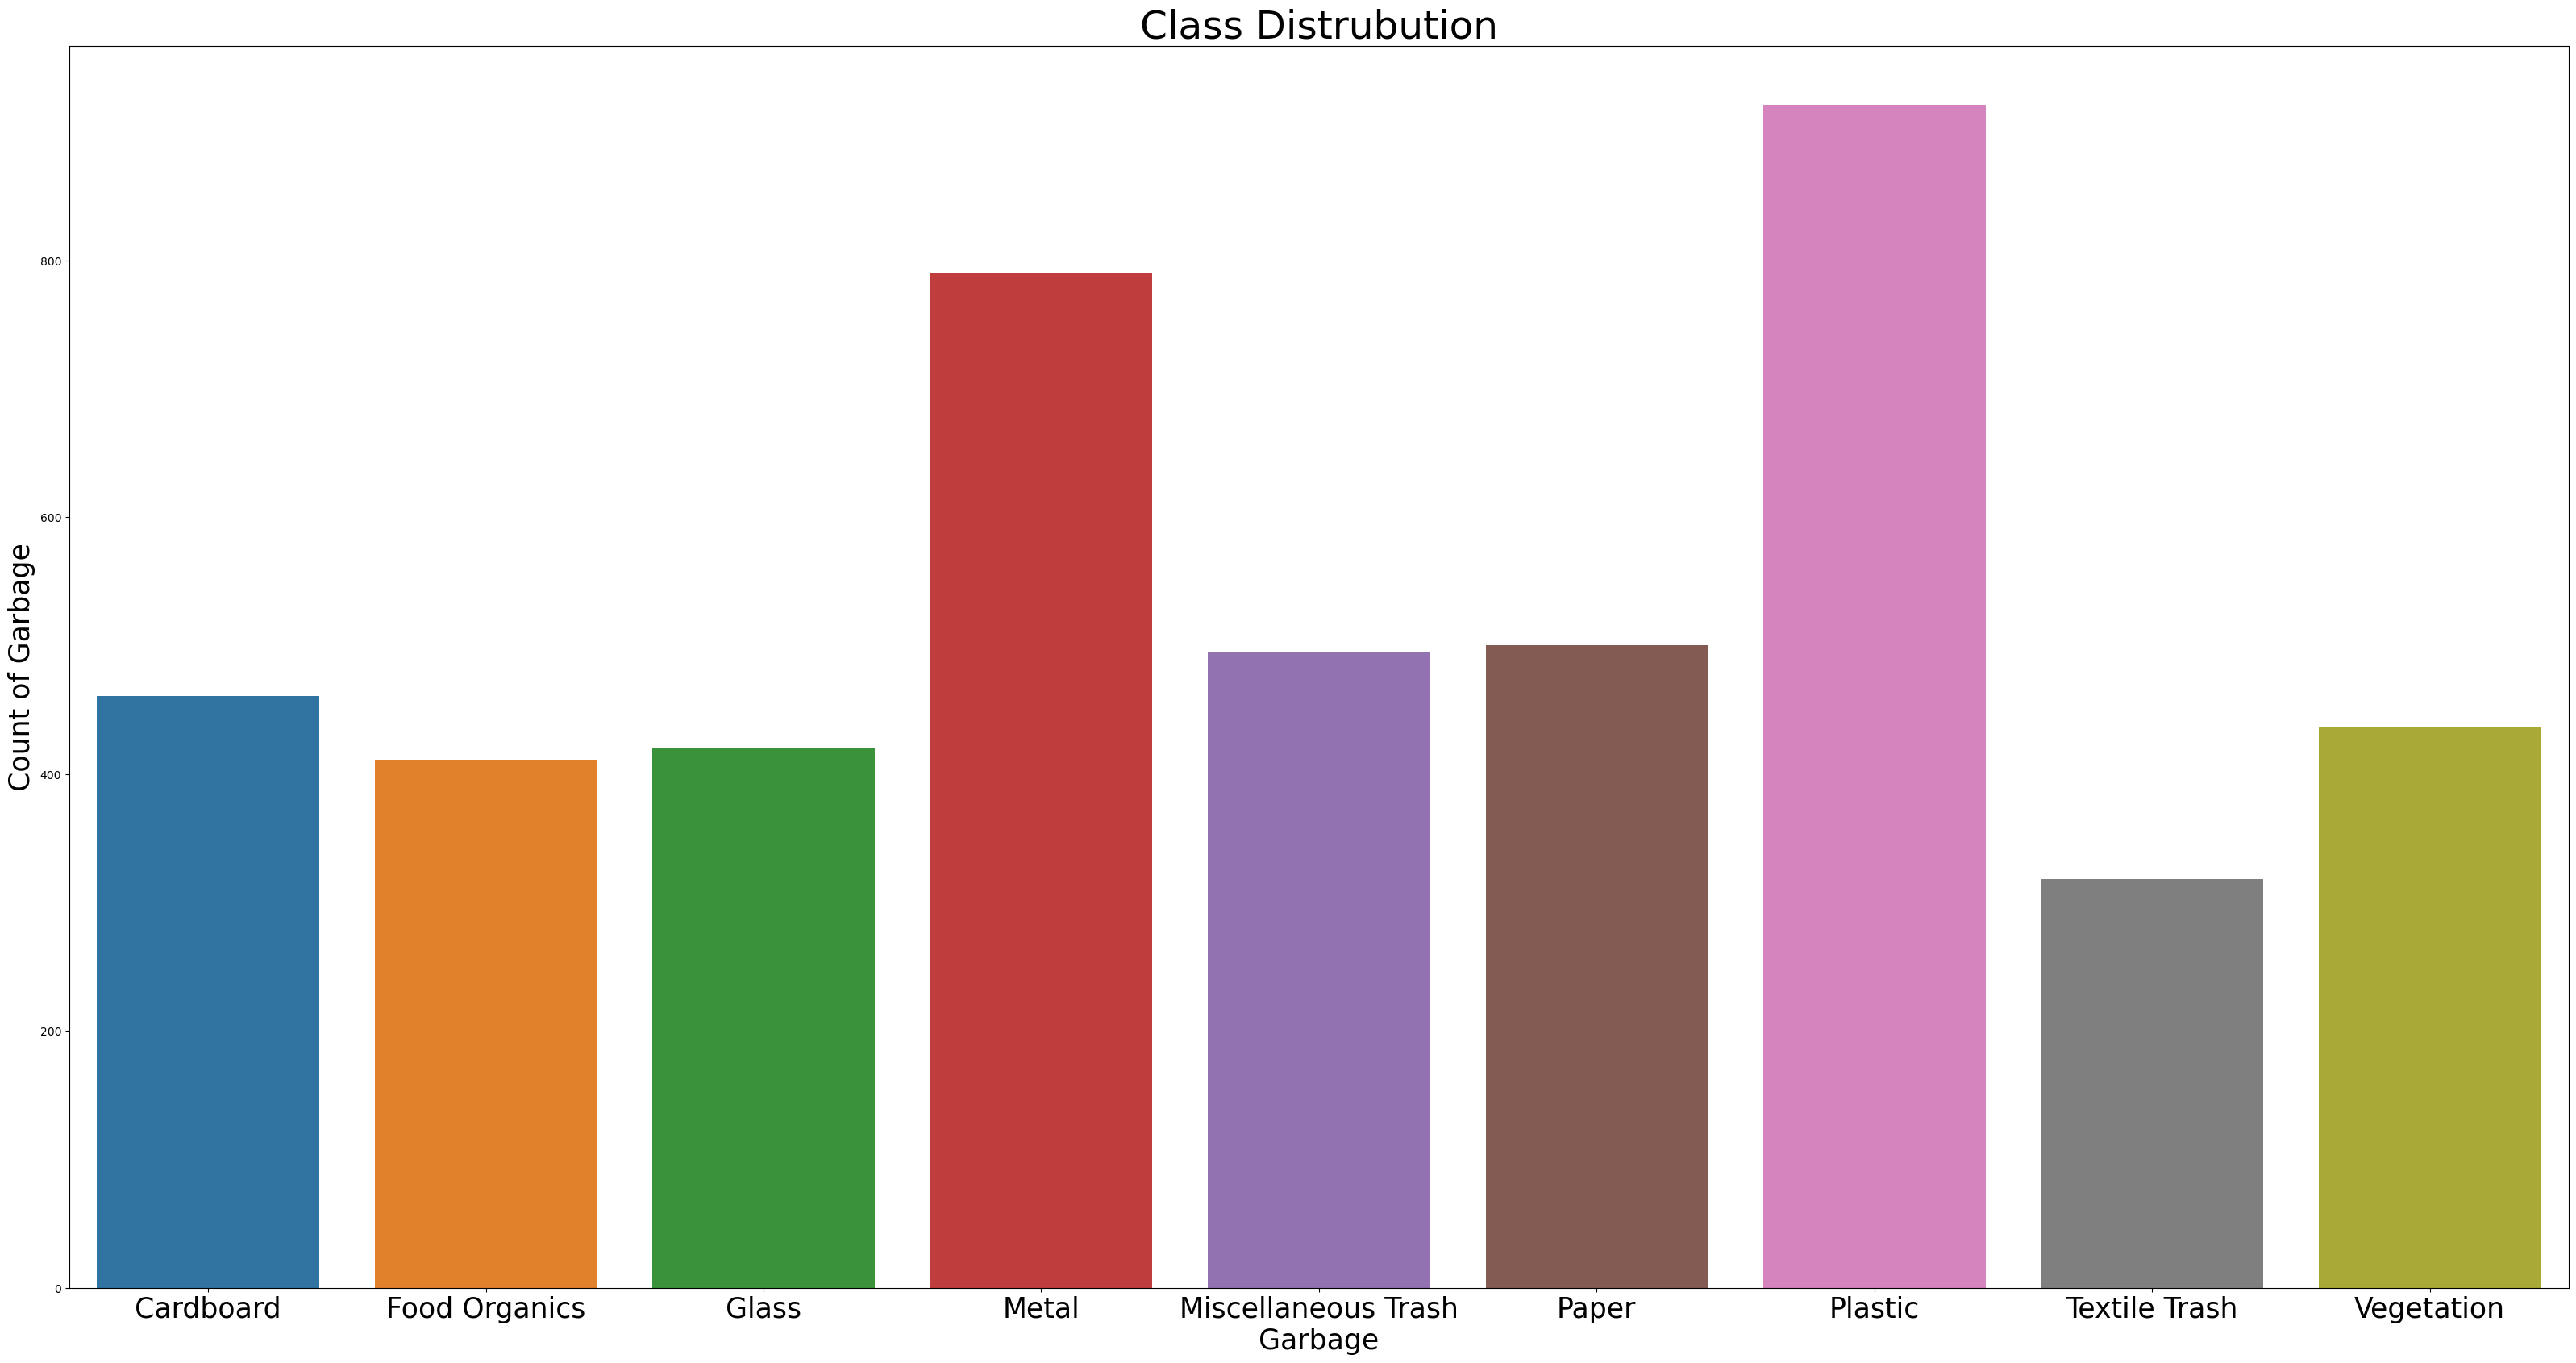

In [11]:
figure_size = plt.rcParams['figure.figsize']
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

sns.barplot(data=samplesize)

index = np.arange(len(original.classes))

plt.xlabel('Garbage', fontsize=25)
plt.ylabel('Count of Garbage', fontsize=25)
plt.xticks(index, original.classes, fontsize=25)
plt.title('Class Distrubution', fontsize=35)
plt.show()

> **Augmented Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


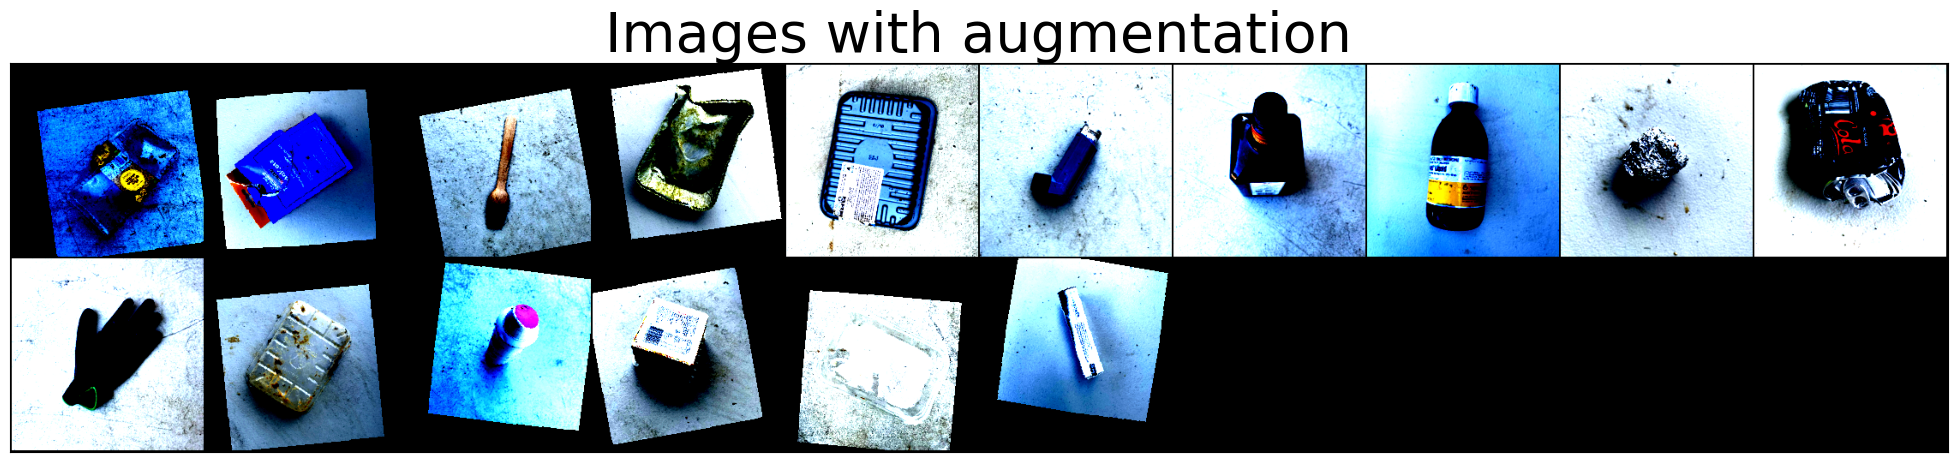

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break
        
show_batch(loaders['train'])

> **Training Code Implementation**

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [18]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

In [19]:
import torch
import torch.nn as nn
import time
import copy

def train(seed, epochs, model):

    print('Creating a model {}...'.format(seed))

    model.to(device)  
    criterion = nn.CrossEntropyLoss()
    if seed == 2:
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
    else:
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
          
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            if phase == 'train':
                acc = 100. * running_corrects.double() / dataset_sizes[phase]
                scheduler.step(acc)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch+1, epochs))
            print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
            lr.append(scheduler._last_lr)
        
            if phase == 'val':
                print('Time: {}m {}s'.format((time.time()- since) // 60, (time.time()- since) % 60))
                print('==' * 31)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('==' * 31)


    model.load_state_dict(best_model)

    for param in model.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
          
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            if phase == 'train':
                acc = 100. * running_corrects.double() / dataset_sizes[phase]
                scheduler.step(acc)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch+1, epochs))
            print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
            lr.append(scheduler._last_lr)
        
            if phase == 'val':
                print('Time: {}m {}s'.format((time.time()- since) // 60, (time.time()- since) % 60))
                print('==' * 31)    
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('==' * 31)

    model.load_state_dict(best_model)
    return model


> **DenseNet121 Implementation**

In [20]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
    param.requires_grad=False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features, out_features=len(original.classes), bias=True)

> **ConvNext Implementation**

In [21]:
convnext = torchvision.models.convnext_tiny (pretrained=True)
for param in convnext.parameters():
    param.grad_requires = False
convnext.classifier[2] = nn.Linear(in_features=768,out_features=9, bias=True)

> **Training Starts Here**

In [22]:
num_models = 2
epochs = 10

models = [convnext, densenet121_0]

for seed in range(num_models):
    train(seed=seed, epochs=epochs, model=models[seed])

Creating a model 0...
Epoch: 1/10
train - loss:0.7539273867611318, accuracy0.7608159022995972
val - loss:0.46716941739911233, accuracy0.8516355140186915
Time: 10.0m 45.37677502632141s
Epoch: 2/10
train - loss:0.4269688073373272, accuracy0.8551383655969858
val - loss:0.3788813450069071, accuracy0.8855140186915887
Time: 22.0m 30.107117414474487s
Epoch: 3/10
train - loss:0.34827271843656615, accuracy0.8847602962193062
val - loss:0.3326523776087805, accuracy0.889018691588785
Time: 33.0m 16.708029747009277s
Epoch: 4/10
train - loss:0.30049340487547954, accuracy0.9006106275172144
val - loss:0.31984308932986216, accuracy0.8925233644859812
Time: 46.0m 31.029608726501465s
Epoch: 5/10
train - loss:0.2664272678840305, accuracy0.9107444458880083
val - loss:0.30086238382854197, accuracy0.9053738317757009
Time: 61.0m 10.908459424972534s
Epoch: 6/10
train - loss:0.24221944788057534, accuracy0.9204885020137715
val - loss:0.29083346269119564, accuracy0.9053738317757009
Time: 72.0m 31.832924365997314s
E

Epoch: 6/10
train - loss:0.001142711818371415, accuracy1.0
val - loss:0.0944558793818143, accuracy0.9661214953271028
Time: 28.0m 29.544663190841675s
Epoch: 7/10
train - loss:0.001070492217994571, accuracy1.0
val - loss:0.09430805734732997, accuracy0.9661214953271028
Time: 31.0m 16.268301486968994s
Epoch: 8/10
train - loss:0.001009270479972562, accuracy1.0
val - loss:0.0942761144191723, accuracy0.9661214953271028
Time: 34.0m 3.0370430946350098s
Epoch: 9/10
train - loss:0.0010002852796010767, accuracy1.0
val - loss:0.09424214386685847, accuracy0.9661214953271028
Time: 36.0m 49.60863733291626s
Epoch: 10/10
train - loss:0.000989125771524245, accuracy1.0
val - loss:0.09420570469609349, accuracy0.9661214953271028
Time: 39.0m 36.36213159561157s
ALL NET TRAINING TIME 39.0m 36.36213159561157s


> **Saving The Models for later**

In [5]:
convnext= torch.load("convnext.pth", map_location=torch.device('cpu'))  
densenet121_0 = torch.load("densenet121_0.pth", map_location=torch.device('cpu'))  


In [23]:
models = [convnext, densenet121_0]

# Evaluation

## First Let's change the values from non tensor to tensor types for the loss as it is being monitored manually 

In [44]:
import torch

def all_tensors(lst):
    return all(isinstance(item, torch.Tensor) for item in lst)


if not all_tensors(losses['train']) or not all_tensors(losses['val']):
    print("Error: Data contains non-tensor elements.")

    non_tensor_train = [item for item in losses['train'] if not isinstance(item, torch.Tensor)]
    non_tensor_val = [item for item in losses['val'] if not isinstance(item, torch.Tensor)]
    print("Non-tensor elements in losses['train']: ", non_tensor_train)
    print("Non-tensor elements in losses['val']: ", non_tensor_val)

else:
    # Conversion 
    losses['train'] = [torch.tensor(loss) if not isinstance(loss, torch.Tensor) else loss for loss in losses['train']]
    losses['val'] = [torch.tensor(loss) if not isinstance(loss, torch.Tensor) else loss for loss in losses['val']]
    print("All OK!")

All OK!


> **Putting Models in Evaluation Mode** -  for Weights to Freeze

In [55]:
convnext.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [56]:
densenet121_0.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

>**Evaluating With Confusion Matrix**

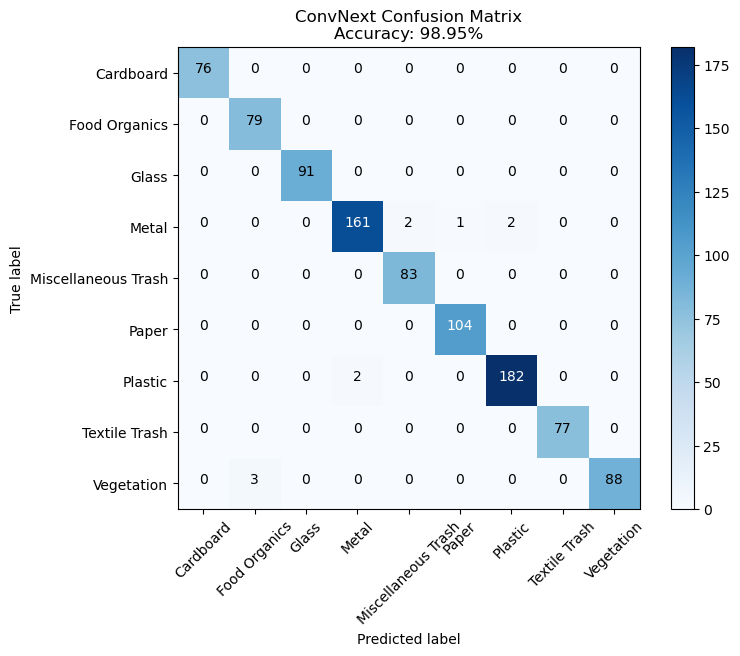

In [30]:
loaders_test = loaders['test']
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in loaders_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = convnext(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(y_true, y_pred)

# accuracy 
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
misclass = 1 - accuracy

# Plot 
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]),
                 horizontalalignment="center", color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.title('ConvNext Confusion Matrix\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.colorbar()
plt.xticks(np.arange(len(original.classes)), original.classes, rotation=45)
plt.yticks(np.arange(len(original.classes)), original.classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

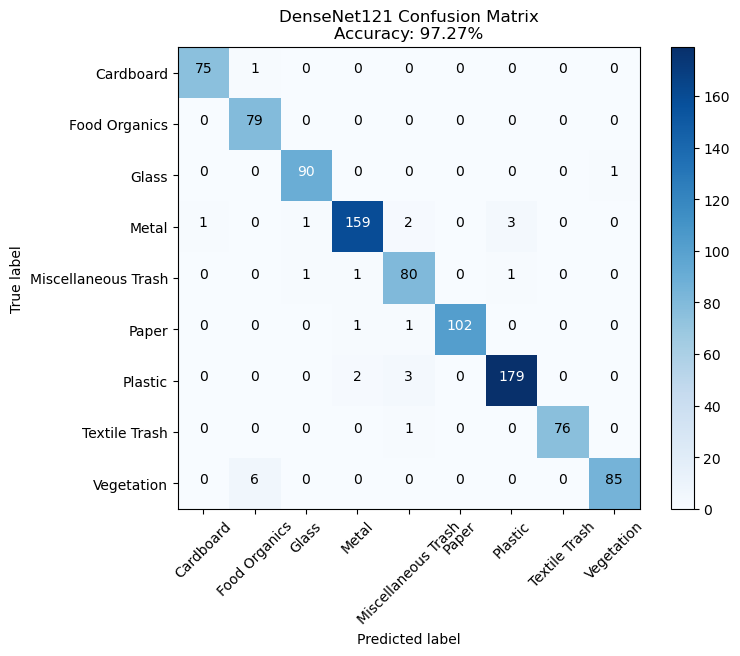

In [31]:
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in loaders_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = densenet121_0(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(y_true, y_pred)

# accuracy 
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
misclass = 1 - accuracy

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]),
                 horizontalalignment="center", color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2 else "black")

plt.title('DenseNet121 Confusion Matrix\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.colorbar()
plt.xticks(np.arange(len(original.classes)), original.classes, rotation=45)
plt.yticks(np.arange(len(original.classes)), original.classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

>**Evaluating with Model Summary - Classification Report**

In [34]:
from sklearn.metrics import classification_report

class_names = original.classes


predictions = {}
true_labels = {}

# Evaluate models
for idx, model in enumerate(models):
    model.eval()
    model_predictions = []
    model_true_labels = []
    with torch.no_grad():
        for inputs, labels in loaders['test']: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            model_predictions.extend(predicted.cpu().numpy())
            model_true_labels.extend(labels.cpu().numpy())
    predictions[f'Model_{idx}'] = model_predictions
    true_labels[f'Model_{idx}'] = model_true_labels

# Convert class indices to class names 
for model_name, model_predictions in predictions.items():
    mod_name=""
    if model_name == "Model_0":
        mod_name="ConvNext"
    else:
        mod_name="DenseNet121"
    true_labels_model = true_labels[model_name]
    model_predictions_labels = [class_names[i] for i in model_predictions]
    true_labels_model_labels = [class_names[i] for i in true_labels_model]
    class_report = classification_report(true_labels_model_labels, model_predictions_labels, target_names=class_names)
    print(f"Classification Report for {mod_name}:")
    print(class_report)


Classification Report for ConvNext:
                     precision    recall  f1-score   support

          Cardboard       1.00      1.00      1.00        76
      Food Organics       0.96      1.00      0.98        79
              Glass       1.00      1.00      1.00        91
              Metal       0.99      0.97      0.98       166
Miscellaneous Trash       0.98      1.00      0.99        83
              Paper       0.99      1.00      1.00       104
            Plastic       0.99      0.99      0.99       184
      Textile Trash       1.00      1.00      1.00        77
         Vegetation       1.00      0.97      0.98        91

           accuracy                           0.99       951
          macro avg       0.99      0.99      0.99       951
       weighted avg       0.99      0.99      0.99       951

Classification Report for DenseNet121:
                     precision    recall  f1-score   support

          Cardboard       0.99      0.99      0.99        76
      

> **Model Accuracy and Loss Line Graph**

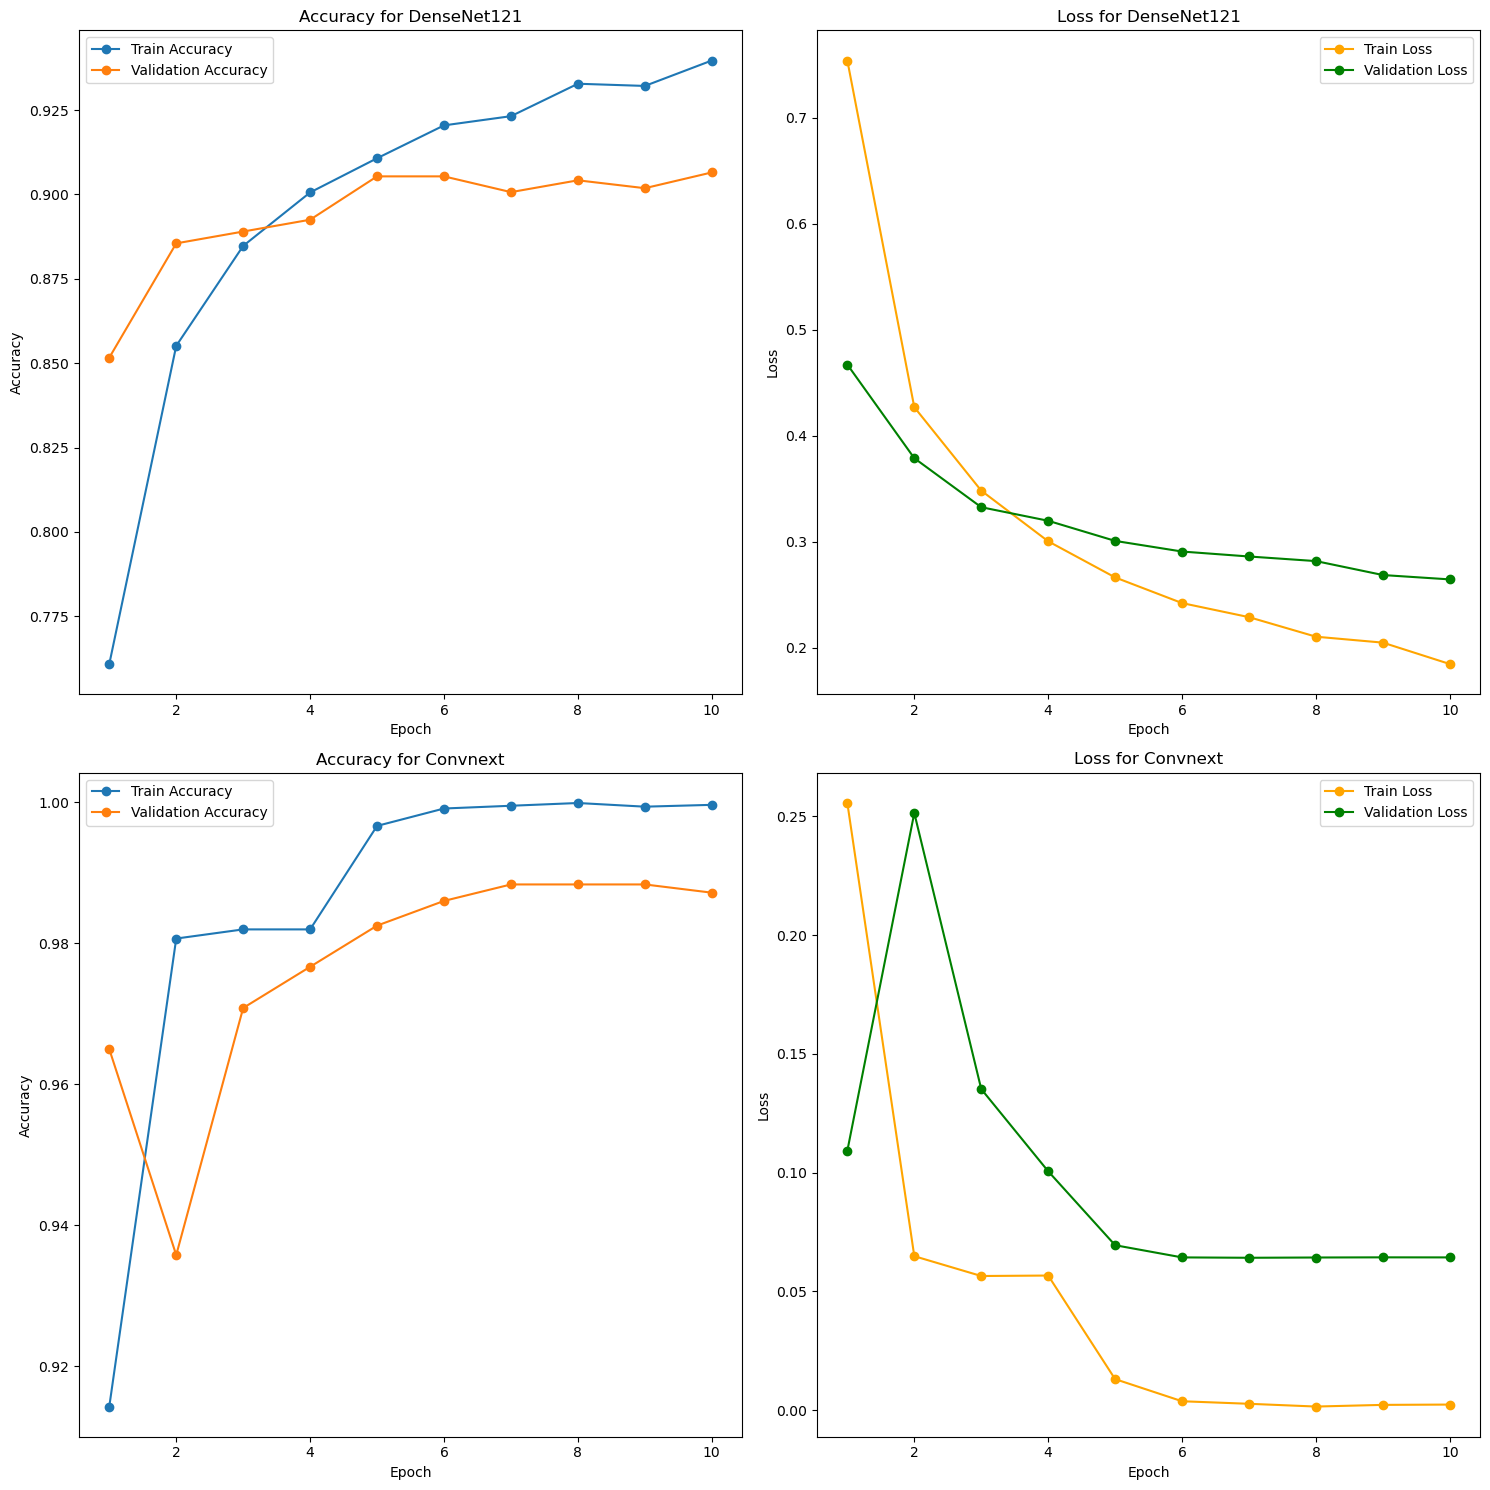

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
modelname = ['DenseNet121', 'Convnext']

for row in range(2): 
    epoch_list = list(range(1, num_epochs + 1)) 


    model_train_acc = [acc.cpu() for acc in accuracies['train'][row * num_epochs:(row + 1) * num_epochs]]
    model_val_acc = [acc.cpu() for acc in accuracies['val'][row * num_epochs:(row + 1) * num_epochs]]


    ax[row][0].plot(epoch_list, model_train_acc, '-o', label='Train Accuracy')
    ax[row][0].plot(epoch_list, model_val_acc, '-o', label='Validation Accuracy')
    ax[row][0].set_xlabel('Epoch')
    ax[row][0].set_ylabel('Accuracy')
    ax[row][0].set_title(f'Accuracy for {modelname[row]}')
    ax[row][0].legend()


    model_train_loss = [loss.cpu() for loss in losses['train'][row * num_epochs:(row + 1) * num_epochs]]
    model_val_loss = [loss.cpu() for loss in losses['val'][row * num_epochs:(row + 1) * num_epochs]]


    ax[row][1].plot(epoch_list, model_train_loss, '-o', color='orange', label='Train Loss')
    ax[row][1].plot(epoch_list, model_val_loss, '-o', color='green', label='Validation Loss')
    ax[row][1].set_xlabel('Epoch')
    ax[row][1].set_ylabel('Loss')
    ax[row][1].set_title(f'Loss for {modelname[row]}')
    ax[row][1].legend()

plt.tight_layout()
plt.show()


## Random Testing

>**Images Over Internet**

DenseNet121_0 Prediction: Cardboard
Cardboard      : 0.978295               prob: 97.83%
Food Organics  : 0.000001               prob: 0.00%
Glass          : 0.000098               prob: 0.01%
Metal          : 0.020550               prob: 2.06%
Miscellaneous Trash: 0.000024               prob: 0.00%
Paper          : 0.000902               prob: 0.09%
Plastic        : 0.000128               prob: 0.01%
Textile Trash  : 0.000001               prob: 0.00%
Vegetation     : 0.000001               prob: 0.00%
------------------------------------------------------------------------
ConvNext Prediction: Cardboard
Cardboard      : 0.999707               prob: 99.97%
Food Organics  : 0.000001               prob: 0.00%
Glass          : 0.000001               prob: 0.00%
Metal          : 0.000133               prob: 0.01%
Miscellaneous Trash: 0.000007               prob: 0.00%
Paper          : 0.000142               prob: 0.01%
Plastic        : 0.000001               prob: 0.00%
Textile Trash  : 0

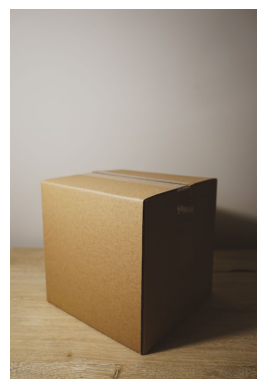

In [52]:
import requests
import io 
from io import BytesIO

image_url = "https://images.unsplash.com/photo-1577705998148-6da4f3963bc8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Nnx8Y2FyZGJvYXJkfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"

def classify_image_from_url(image_url, model, classes):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = preprocess(img).unsqueeze(0)
    
    device = next(model.parameters()).device
    img = img.to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    probabilities_list = probabilities.cpu().numpy().tolist()
    
    predicted_class_idx = torch.argmax(probabilities).item()
    predicted_class = classes[predicted_class_idx]
    
    class_probabilities = {class_name: probability for class_name, probability in zip(classes, probabilities_list)}
    
    return predicted_class, class_probabilities


predicted_class_densenet121_0, probs_densenet121_0 = classify_image_from_url(image_url, densenet121_0, original.classes)
print("DenseNet121_0 Prediction:", predicted_class_densenet121_0)
for i,v in probs_densenet121_0.items():
    print("{:15}: {:.6f}               prob: {:.2f}%".format(i, v, v*100))
print("------------------------------------------------------------------------")

predicted_class_convnext, probs_convnext = classify_image_from_url(image_url, convnext, original.classes)
print("ConvNext Prediction:", predicted_class_convnext)
for i,v in probs_convnext.items():
    print("{:15}: {:.6f}               prob: {:.2f}%".format(i, v, v*100))

response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.axis('off')
plt.show()
